In [3]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
class ActorCritic(nn.Module):
    def __init__(self,state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim,64)
        self.fc2 = nn.Linear(64, 64)
        self.fc_pi = nn.Linear(64, action_dim)
        self.fc_v = nn.Linear(64, 1)
    
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        pi = torch.softmax(self.fc_pi(x), dim=0)
        v = self.fc_v(x)
        return pi, v


In [14]:
env = gym.make('CartPole-v1', max_episode_steps=100, render_mode = "human")
num_episodes = 100
discount_factor = 0.89
learning_rate = 1e-6
state, info = env.reset()
n_observations = len(state)
agent = ActorCritic(n_observations, env.action_space.n)
optimizer = optim.Adam(agent.parameters(), lr = learning_rate)


In [15]:
Rewards = []
for episode in range(num_episodes):

    state,_ = env.reset()
    done = False
    total_reward = 0
    while not done:

        probs, val = agent(torch.tensor(state, dtype = torch.float32))
        action = np.random.choice(np.arange(len(probs)), p=probs.detach().numpy())

        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward

        ##Calculate TD error and Loss

        _, next_val = agent(torch.tensor(next_state, dtype = torch.float32))
        err = reward + discount_factor*(next_val*(1-done))- val
        actor_loss = -torch.log(probs[action])*err
        critic_loss = torch.square(err)
        loss = actor_loss + critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state
    Rewards.append(total_reward)

        

Text(0.5, 0, 'Episodes')

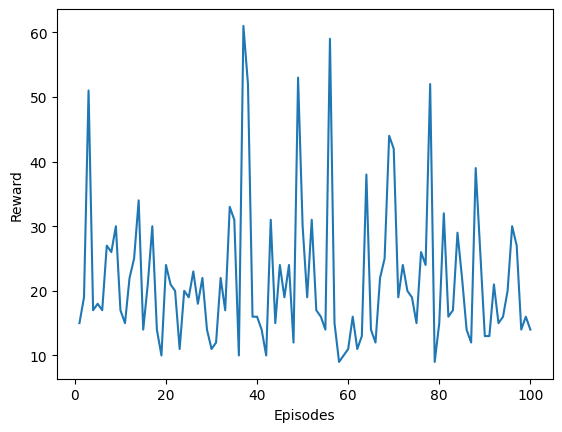

In [16]:

episodes = [i for i in range(1,num_episodes+1)]
plt.plot(episodes, Rewards)
plt.ylabel("Reward")
plt.xlabel("Episodes")